In [1]:
import pandas as pd 
import numpy as np 
import networkx as nx

np.random.seed(42)
SEED = 42

## Create random gene sets and contaminated ones 

* random: same size as the selected term, draw genes from the pool that is not in the systems with direct connection with the real gene set 

* contaimnated: same size as the selected term, randomly perserve 50% of them (roof) and the rest 50% randomly select from the random gene set. 

In [2]:
full_GO = pd.read_csv('data/go_terms.csv', index_col=0)
selected_go = pd.read_csv('data/GO_term_analysis/1000_selected_go_terms.csv')
go_edges = pd.read_csv('./data/GO_BP/collapsed_go.symbol', sep='\t', header=None, names=['parent', 'child', 'edge_type'])
go_edges = go_edges[go_edges['edge_type'] == 'default']

In [3]:
def find_direct_connections(go_id, edge_list):
    direct_connections = edge_list.loc[(edge_list['parent'] == go_id), 'child'].tolist()
    # print(len(direct_connections))
    direct_connections.extend(edge_list.loc[(edge_list['child'] == go_id), 'parent'].tolist())
    direct_connections = list(set(direct_connections))
    return direct_connections

# find_direct_connections(go_id, go_edges)


In [4]:
def get_gene_pool(go_id, edge_list, go_terms):
    '''
    go_id: the go term id
    edge_list: the edge list of the go terms
    go_terms: the full go terms dataframe
    '''
    gene_pool = set(gene for genes in go_terms['Genes'].apply(lambda x: x.split(' ')) for gene in genes)
    # print(len(gene_pool))
    direct_connections = find_direct_connections(go_id, edge_list)
    # exclude genes from direct connection terms
    direct_connection_pool = go_terms[go_terms['GO'].isin(direct_connections+ [go_id])]
    direct_connection_genes = set(gene for genes in direct_connection_pool['Genes'].apply(lambda x: x.split(' ')) for gene in genes)
    # print(len(direct_connection_genes))
    
    filtered_gene_pool = gene_pool - direct_connection_genes
    
    current_genes = go_terms.loc[go_terms['GO'] == go_id, 'Genes'].tolist()[0].split(' ')
    # print(len(current_genes))
    
    # check if theres any genes in the pool overlaps with the ones in go_id
    # print(len(filtered_gene_pool))
    assert len(set(current_genes).intersection(filtered_gene_pool)) == 0, 'Warning: genes in the pool overlaps with the ones in this real set'
    return filtered_gene_pool


def add_contamination(go_id, edge_list, go_terms, contamination_rate=0.5):
    '''
    contamination_rate: the percentage of genes to be contaminated
    '''
    random_pool = get_gene_pool(go_id, edge_list, go_terms)
    current_genes = go_terms.loc[go_terms['GO'] == go_id, 'Genes'].tolist()[0].split(' ')
    # print(current_genes)
    contamination_size = int(np.ceil(len(current_genes) * contamination_rate))
    contamination_genes = np.random.choice(list(random_pool), size=contamination_size, replace=False)
    perserve_genes = np.random.choice(current_genes, size=len(current_genes) - contamination_size, replace=False)
    new_set = list(perserve_genes) + list(contamination_genes)
    assert len(new_set) == len(current_genes), 'length of new set is not the same as the original set'
    return new_set


In [5]:
# add contamination to the toy example
selected_go['50perc_contaminated_Genes'] = selected_go.apply(lambda x: ' '.join(add_contamination(x['GO'], go_edges, full_GO, contamination_rate=0.5)), axis=1)
selected_go['100perc_contaminated_Genes'] = selected_go.apply(lambda x: ' '.join(add_contamination(x['GO'], go_edges, full_GO, contamination_rate=1)), axis=1)
selected_go.to_csv('data/GO_term_analysis/1000_selected_go_contaminated.csv', index=False)

In [6]:
selected_go.head()

,GO,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes
0,GO:0048627,MEGF10 SDC1 WNT10B SOX15,4,myoblast development,MEGF10 WNT10B COL4A5 TMC6,KRTAP4-9 SPAG4 ACOD1 MTHFD2L
1,GO:1904888,CPLANE2 NEUROG1 GRHL2 TGFB3 EXT1 TGFBR2 TWIST1...,72,cranial skeletal system development,TFAP2A SIX4 MTHFD1L FGFR2 GNA11 TGFB3 IFT140 M...,THUMPD1 LMNB2 OR1L3 DESI1 STX19 MAN1A1 PRRT2 F...
2,GO:0019585,DCXR UGT1A9 UGT2B7 PRKCE UGT1A7 UGT2A3 SORD UG...,26,glucuronate metabolic process,AKR1A1 DCXR UGT2A1 UGT2B7 UGT2A2 UGT2B28 UGT1A...,SLC6A1 YLPM1 FIRRM RHEX NAA25 NSMCE1 CLDN7 NDU...
3,GO:1902267,AZIN1 OAZ2 OAZ1 AZIN2 OAZ3,5,regulation of polyamine transmembrane transport,AZIN1 OAZ1 ID2 ZNF573 ZC3H12A,IL16 KPLCE PRMT1 NLRP1 RBP2
4,GO:0019748,BDH2 CYP2A7 AKR1C1 ACMSD ATP7A ASIP DDT CYP3A4...,56,secondary metabolic process,AKR7A2 FMO1 UGT1A8 APPL1 WNT5A SULT1C4 ACMSD M...,RUFY1 SURF6 LCE1B CABLES1 PCDHGA12 COBL SPACA3...


In [7]:
# extract a subset of 10 GO terms as a toy example
import pandas as pd
df = pd.read_csv('data/GO_term_analysis/1000_selected_go_contaminated.csv')
# take random 10 GO terms 

toy = df.sample(n=10, random_state=SEED)
toy.to_csv('data/GO_term_analysis/toy_example_w_contaminated.csv', index=False)

In [8]:
# add a gene set == 100 and run the analysis. add to the toy example file
selected_go_terms = pd.read_csv('data/GO_term_analysis/1000_selected_go_contaminated.csv')

# only one that has gene count == 100
gene_count100 = selected_go_terms[selected_go_terms['Gene_Count'] == 100].reset_index(drop=True)

toy = pd.read_csv('data/GO_term_analysis/toy_example_w_contaminated.csv')
toy = toy.append(gene_count100).reset_index(drop=True)
toy.to_csv('data/GO_term_analysis/toy_example_w_contaminated.csv', index=False)

/var/folders/nx/h6fkpnxn1qz95969ny71ltf00000gn/T/ipykernel_44358/1707226366.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  toy = toy.append(gene_count100).reset_index(drop=True)


['GO:0045940',
 'GO:0010757',
 'GO:2000136',
 'GO:0002433',
 'GO:1990874',
 'GO:0002792',
 'GO:1900368',
 'GO:2000524',
 'GO:2000556',
 'GO:0120253',
 'GO:0090100']

In [9]:
## subsetting 50 genes in this pool that are not in the toy examples 
toy = pd.read_csv('data/GO_term_analysis/toy_example_w_contaminated.csv')
toy_terms = toy['GO'].tolist()

selected_go_terms = pd.read_csv('data/GO_term_analysis/1000_selected_go_contaminated.csv')

# filter out the ones that are in the toy example
filtered_pool = selected_go_terms[~selected_go_terms['GO'].isin(toy_terms)].reset_index(drop=True)

# take random 39 terms from this pool (to make it 50)
toy_pool = filtered_pool.sample(n=89, random_state=SEED).reset_index(drop=True)
toy_pool.to_csv('data/GO_term_analysis/model_comparison_terms.csv', index=False)
toy_pool.head()

,GO,Genes,Gene_Count,Term_Description,50perc_contaminated_Genes,100perc_contaminated_Genes
0,GO:0061740,HSPA8 LAMP2 CLU,3,protein targeting to lysosome involved in chap...,CLU CFTR ZNF780A,MPST SPOP EEF1AKMT4-ECE2
1,GO:0045056,LRP1 PICALM CLTC USO1 VPS35 FCMR RAB5A AGER IG...,21,transcytosis,CLTC VPS35 FCGRT PTAFR RAB11B USO1 LRP1 LRP2 L...,CDC42BPB RANBP2 SRSF5 NUP98 LMF2 ZNF567 CLDN10...
2,GO:0141085,PPP2CA CD36 MARK4 CPTP TREM2 TLR6 ATAT1 FBXL2 ...,39,regulation of inflammasome-mediated signaling ...,PYDC2 BRCC3 USP50 MAVS IRGM PYDC1 GBP2 ZDHHC12...,ENPP1 TUBA3C ZNF280C OR9Q1 CCDC78 UGDH MIXL1 W...
3,GO:0036148,CRLS1 SERAC1 PLA2G4D PLA2G4F LPGAT1 LPCAT4 PLA...,10,phosphatidylglycerol acyl-chain remodeling,JMJD7-PLA2G4B LPGAT1 PLA2G2F PLA2G4F CRLS1 GUC...,MRPL21 TCIRG1 ELOVL1 HSF4 CHST13 TSSK1B CYP4B1...
4,GO:1901797,MIF SIRT1 TWIST1 DYRK1A MUC1 ARMC10 MARCHF7 CD...,33,negative regulation of signal transduction by ...,MDM2 CD74 SNAI1 MUC1 TAF9 PRKN SNAI2 RNF34 HAP...,MND1 HSD17B12 CCNB1 PRAMEF20 PIWIL4 TPPP PDE6D...


/var/folders/nx/h6fkpnxn1qz95969ny71ltf00000gn/T/ipykernel_44358/515370721.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = toy.append(toy_pool).reset_index(drop=True)


(array([34., 21.,  7.,  9.,  3.,  1.,  5.,  2.,  2.,  1.,  1.,  2.,  0.,
         3.,  1.,  0.,  2.,  3.,  0.,  3.]),
 array([  3.  ,   7.85,  12.7 ,  17.55,  22.4 ,  27.25,  32.1 ,  36.95,
         41.8 ,  46.65,  51.5 ,  56.35,  61.2 ,  66.05,  70.9 ,  75.75,
         80.6 ,  85.45,  90.3 ,  95.15, 100.  ]),
 <BarContainer object of 20 artists>)

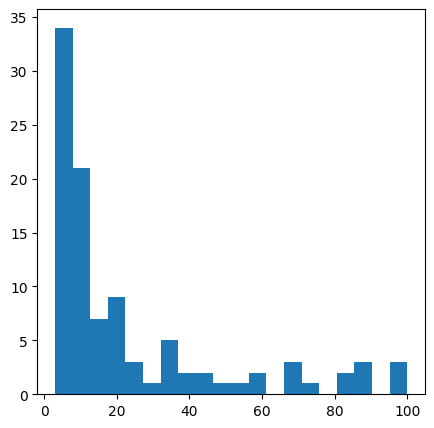

In [10]:
import matplotlib.pyplot as plt

data = toy.append(toy_pool).reset_index(drop=True)

plt.figure(figsize=(5,5))
plt.hist(data['Gene_Count'], bins=20)